This notebook does the following steps:
 

1.   Create the modifed model for Inception-ResNet.
2.   load the simplified vector formats of the images in the quick draw dataset from a folder in my Google Drive cloud storage, each file has an extention of `.ndjson`
3.   Convert the requied number of images into bitmaps
4.   Train the network
5.   Plot the accuracy and loss graphs



Importing the requied Libraries:

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import json
import glob2 as glob
import pickle
 
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.python.keras.engine import training
from tensorflow.python.util.tf_export import kwarg_only

Defining some constant. 
*   `CANVAS_SIZE` is the size of an image that is first used to draw the polygons on a bitmap.
*   `IMAGE_SIZE` is the size of the final bitmap which will be used to train the network
*   `IMAGE_COUNT_PER_CATEGORY` is the number of images in the training set for each category
*   `VALIDATION_IMAGE_COUNT_PER_CATEGORY` is the number of images in the validation set for each category
*   The number of categories is inferred from the number of `.ndjson` files in the folder with the path `'/content/drive/MyDrive/Research/Project_Inception_ResNet/dataset/'` in my Google Drive cloud storage.

In [2]:
CANVAS_SIZE = 262
IMAGE_SIZE = 85
IMAGE_COUNT_PER_CATEGORY = 2000
VALIDATION_IMAGE_COUNT_PER_CATEGORY = 1000
CATEGORY_LIMIT = 53
modelFolder = "/content/drive/MyDrive/Research/Project_Inception_ResNet/RM-Experiments/trainedModelE4_9"

The design of the modifed Inception-ResNet model:

In [3]:
def Stem(inputs):
    
    t = layers.Conv2D(32, (3, 3), strides=(1,1), padding="valid", activation='relu', use_bias=False)(inputs)
    t = layers.Conv2D(32, (3, 3), strides=(1,1), padding="valid", activation='relu', use_bias=False)(t)
    t = layers.Conv2D(64, (3, 3), strides=(2,2), padding="valid", activation='relu', use_bias=False)(t)
    t = layers.Conv2D(64, (1, 1), strides=(1,1), padding="valid", activation='relu', use_bias=False)(t)
    t = layers.Conv2D(64, (3, 3), strides=(1,1), padding="valid", activation='relu', use_bias=False)(t)
    t = layers.Conv2D(64, (3, 3), strides=(1,1), padding="valid", activation='relu', use_bias=False)(t)
    return t
def BlockA(t, scale):
    #branch #1
    t1 = layers.Conv2D(32, (1, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(t)
    #branch #2
    t2 = layers.Conv2D(32, (1, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(t)
    t2 = layers.Conv2D(32, (3, 3), strides=(1,1), padding="same", activation='relu', use_bias=False)(t2)
    #branch #3
    t3 = layers.Conv2D(32, (1, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(t)
    t3 = layers.Conv2D(32, (1, 7), strides=(1,1), padding="same", activation='relu', use_bias=False)(t3)
    t3 = layers.Conv2D(32, (7, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(t3)
    conc = layers.Concatenate(axis=3)([t1, t2, t3])
    conc = layers.Conv2D(64, (1, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(conc)
    t = layers.Add()([t, conc*scale])

    return t

def ReductionA(t):
    #branch #1
    t1 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="valid")(t)
    #branch #2
    t2 = layers.Conv2D(128, (3, 3), strides=(2,2), padding="valid", activation='relu', use_bias=False)(t)
    #branch #3
    t3 = layers.Conv2D(64, (1, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(t)
    t3 = layers.Conv2D(64, (3, 3), strides=(1,1), padding="same", activation='relu', use_bias=False)(t3)
    t3 = layers.Conv2D(64, (3, 3), strides=(2,2), padding="valid", activation='relu', use_bias=False)(t3)
    
    conc = layers.Concatenate(axis=3)([t1, t2, t3])
    
    return conc

def BlockB(t, scale):
    #branch #1
    t1 = layers.Conv2D(128, (1, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(t)
    #branch #2
    t2 = layers.Conv2D(128, (1, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(t)
    t2 = layers.Conv2D(128, (1, 7), strides=(1,1), padding="same", activation='relu', use_bias=False)(t2)
    t2 = layers.Conv2D(128, (7, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(t2)
    
    conc = layers.Concatenate(axis=3)([t1, t2])
    conc = layers.Conv2D(256, (1, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(conc)
    t = layers.Add()([t, conc*scale])

    return t


def ReductionB(t):
    #branch #1:
    t1 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="valid")(t)
    #branch #2
    t2 = layers.Conv2D(96, (1, 1), strides=(1,1), padding="valid", activation='relu', use_bias=False)(t)
    t2 = layers.Conv2D(96, (3, 3), strides=(2,2), padding="valid", activation='relu', use_bias=False)(t2)
    #branch #3
    t3 = layers.Conv2D(64, (1, 1), strides=(1,1), padding="valid", activation='relu', use_bias=False)(t)
    t3 = layers.Conv2D(64, (3, 3), strides=(2,2), padding="valid", activation='relu', use_bias=False)(t3)
    #branch #4
    t4 = layers.Conv2D(64, (1, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(t)
    t4 = layers.Conv2D(64, (3, 3), strides=(1,1), padding="same", activation='relu', use_bias=False)(t4)
    t4 = layers.Conv2D(64, (3, 3), strides=(2,2), padding="valid", activation='relu', use_bias=False)(t4)

    conc = layers.Concatenate(axis=3)([t1, t2, t3, t4])
    
    return conc


def BlockC(t, scale):
    #branch #1
    t1 = layers.Conv2D(192, (1, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(t)
    #branch #2
    t2 = layers.Conv2D(192, (1, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(t)
    t2 = layers.Conv2D(192, (1, 3), strides=(1,1), padding="same", activation='relu', use_bias=False)(t2)
    t2 = layers.Conv2D(192, (3, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(t2)
    
    conc = layers.Concatenate(axis=3)([t1, t2])
    conc = layers.Conv2D(480, (1, 1), strides=(1,1), padding="same", activation='relu', use_bias=False)(conc)
    t = layers.Add()([t, conc*scale])

    return t

def InceptionResNet(categories):
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

    t = Stem(inputs)

    for i in range(5):
          t = BlockA(t, 0.17)
    t = ReductionA(t)

    for i in range(10):
        t = BlockB(t, 0.1)
    
    t = ReductionB(t)

    for i in range(5):
            t = BlockC(t, 0.1) #lambda i: 1 if i == 4 else 0.1)
      
    t = layers.GlobalAveragePooling2D()(t)
  
    t = layers.Dropout(0.8)(t)

    t = layers.Dense(categories)(t) #Softmax

    model = tf.keras.Model(inputs=inputs, outputs=t)
    
    return model

Defining lists for trainig and validation sets:
*  `train_images`: a list of bitmaps for training the model
*  `trainig_labels`: a list of labels corresponding to the category which each image in the training set is in.
*  `validation_images`: a list of bitmaps for validating the model
*  `validation_labels`: a list of labels corresponding to the category which each image in the validation set is in.

In [4]:
train_images = []
validation_images = []
train_labels = []
validation_labels = []


The block of code that reads .ndjson files and generates the bitmaps.

In [5]:
categories = 0
#This loop is repeated for each .ndjson (each category) or the limit on the number of categories
for filename in glob.glob('/content/drive/MyDrive/Research/Project_Inception_ResNet/dataset/*.ndjson'):
    if (categories == CATEGORY_LIMIT):
      break
    print(filename)
    with open(filename) as file:
        categories += 1
        isInstance = True
        #limit indicates the number of images that should be read from the .ndjson file
        limit = IMAGE_COUNT_PER_CATEGORY + VALIDATION_IMAGE_COUNT_PER_CATEGORY
        #for each category, before saving images in train_images and 
        #validation_images lists, they are stored in imgs list:
        imgs = []
        t = 0
        #this loop is repeated for each image that should be converted
        #to bitmap in a category
        while isInstance and t < limit:
            instance = file.readline()
            isInstance = instance != ""
            if (isInstance):
                dict = json.loads(instance)  
                
                img = np.zeros((CANVAS_SIZE,CANVAS_SIZE,1), np.uint8)
                
                min0 = 256
                max0 = 0
                min1 = 256
                max1 = 0
                for polygon in dict["drawing"]:
                    min0 = min(min0, min(polygon[0]))
                    max0 = max(max0, max(polygon[0]))
                    min1 = min(min1, min(polygon[1]))
                    max1 = max(max1, max(polygon[1]))
                #offset variables help us to center the image inside the bitmap
                #instead of it being on the top left corner.
                offset0 = int((CANVAS_SIZE - (max0 - min0))/2)
                offset1 = int((CANVAS_SIZE - (max1 - min1))/2)

                #This nested for loop, draws the lines on the bitmap
                for polygon in dict["drawing"]:
                    for i in range(0, len(polygon[0]) - 1):
                        cv.line(img,(offset0 + polygon[0][i], offset1 + polygon[1][i]),(offset0 + polygon[0][i + 1],offset1 + polygon[1][i + 1]),1,5)
                img = cv.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
                img = np.array(img, dtype=np.bool)
                imgs.append(img)
            
            t += 1

          
        imgs2d = np.reshape(imgs, (-1, IMAGE_SIZE*IMAGE_SIZE))
        
        train_images.append(imgs2d[0:IMAGE_COUNT_PER_CATEGORY])
        validation_images.append(imgs2d[IMAGE_COUNT_PER_CATEGORY:IMAGE_COUNT_PER_CATEGORY + VALIDATION_IMAGE_COUNT_PER_CATEGORY])
        train_labels.append(np.ones((IMAGE_COUNT_PER_CATEGORY, 1)) * (categories - 1))
        validation_labels.append(np.ones((VALIDATION_IMAGE_COUNT_PER_CATEGORY, 1)) * (categories - 1))

        print(str.format("processed {a} new images, total: {b}", a = len(imgs), b = len(train_images)))
        imgs2d = []
        imgs = []

/content/drive/MyDrive/Research/Project_Inception_ResNet/dataset/full_simplified_The Eiffel Tower.ndjson
processed 3000 new images, total: 1
/content/drive/MyDrive/Research/Project_Inception_ResNet/dataset/full_simplified_anvil.ndjson
processed 3000 new images, total: 2
/content/drive/MyDrive/Research/Project_Inception_ResNet/dataset/full_simplified_apple.ndjson
processed 3000 new images, total: 3
/content/drive/MyDrive/Research/Project_Inception_ResNet/dataset/full_simplified_bat.ndjson
processed 3000 new images, total: 4
/content/drive/MyDrive/Research/Project_Inception_ResNet/dataset/full_simplified_bicycle.ndjson
processed 3000 new images, total: 5
/content/drive/MyDrive/Research/Project_Inception_ResNet/dataset/full_simplified_bridge.ndjson
processed 3000 new images, total: 6
/content/drive/MyDrive/Research/Project_Inception_ResNet/dataset/full_simplified_banana.ndjson
processed 3000 new images, total: 7
/content/drive/MyDrive/Research/Project_Inception_ResNet/dataset/full_simplif

Images and labels are reshaped to the same shape that is requied by the TensorFlow Keras API

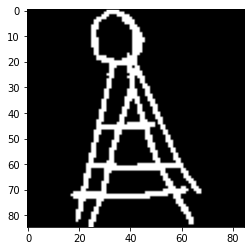

In [6]:
train_images = np.reshape(train_images, (-1, IMAGE_SIZE, IMAGE_SIZE, 1))
train_labels = np.reshape(train_labels, (-1, 1))
validation_images = np.reshape(validation_images, (-1, IMAGE_SIZE, IMAGE_SIZE, 1))
validation_labels = np.reshape(validation_labels, (-1, 1))
plt.imshow(np.reshape(train_images[127], (IMAGE_SIZE, IMAGE_SIZE)), cmap="gray")

This block of code creates train and validation datasets, instaciates a model, and train and validate the model with the created datasets

In [7]:

print(np.shape(train_images))
print(np.shape(validation_images))

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

train_dataset = train_dataset.shuffle(categories * IMAGE_COUNT_PER_CATEGORY).batch(100)
model = InceptionResNet(categories)
model.summary()
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
history = model.fit(train_dataset, validation_data = (validation_images, validation_labels), epochs=12)
 

(106000, 85, 85, 1)
(53000, 85, 85, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 85, 85, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 83, 83, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 81, 81, 32)   9216        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 40, 40, 64)   18432       conv2d_1[0][0]                   
_______________________________________________________

In [8]:
#history = model.fit(train_dataset, validation_data = (validation_images, validation_labels), epochs=5)


This line of code saves the model into my Google Drive cloud storage, to be later converted into a TensorFlow Lite model.

In [9]:
model.save(modelFolder)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Research/Project_Inception_ResNet/RM-Experiments/trainedModelE4_9/assets


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [13]:
with open(modelFolder + '/trainHistory', 'wb') as file:
  pickle.dump(history.history, file)

In [14]:
with open(modelFolder + '/trainHistory', 'rb') as file:
  a = pickle.load(file)
a

{'accuracy': [0.16012264788150787,
  0.5444528460502625,
  0.7035660147666931,
  0.7709622383117676,
  0.8046037554740906,
  0.8259150981903076,
  0.843518853187561,
  0.855198085308075,
  0.8653207421302795,
  0.8748584985733032,
  0.8829150795936584,
  0.8887641429901123],
 'loss': [3.260443687438965,
  1.71091890335083,
  1.1404787302017212,
  0.9002271294593811,
  0.7728311419487,
  0.6898002028465271,
  0.6218777894973755,
  0.5739463567733765,
  0.5354728698730469,
  0.5005540251731873,
  0.46673381328582764,
  0.4389508366584778],
 'val_accuracy': [0.4707735776901245,
  0.7062641382217407,
  0.7850377559661865,
  0.8198113441467285,
  0.8304528594017029,
  0.8446981310844421,
  0.8530754446983337,
  0.8523962497711182,
  0.8595660328865051,
  0.859754741191864,
  0.8622264266014099,
  0.864301860332489],
 'val_loss': [2.001549243927002,
  1.1210637092590332,
  0.8337591290473938,
  0.7206249833106995,
  0.6897933483123779,
  0.6241106390953064,
  0.5907723903656006,
  0.60414224

{'accuracy': [0.16012264788150787,
  0.5444528460502625,
  0.7035660147666931,
  0.7709622383117676,
  0.8046037554740906,
  0.8259150981903076,
  0.843518853187561,
  0.855198085308075,
  0.8653207421302795,
  0.8748584985733032,
  0.8829150795936584,
  0.8887641429901123],
 'loss': [3.260443687438965,
  1.71091890335083,
  1.1404787302017212,
  0.9002271294593811,
  0.7728311419487,
  0.6898002028465271,
  0.6218777894973755,
  0.5739463567733765,
  0.5354728698730469,
  0.5005540251731873,
  0.46673381328582764,
  0.4389508366584778],
 'val_accuracy': [0.4707735776901245,
  0.7062641382217407,
  0.7850377559661865,
  0.8198113441467285,
  0.8304528594017029,
  0.8446981310844421,
  0.8530754446983337,
  0.8523962497711182,
  0.8595660328865051,
  0.859754741191864,
  0.8622264266014099,
  0.864301860332489],
 'val_loss': [2.001549243927002,
  1.1210637092590332,
  0.8337591290473938,
  0.7206249833106995,
  0.6897933483123779,
  0.6241106390953064,
  0.5907723903656006,
  0.60414224